In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

import itertools
from scipy.interpolate import interp1d

In [3]:
Model_Mode = 'Periods' #["IC", "Channels", "Periods", "Time"];

Modality = 'EEGfMRI'; # EEG MEG GMEG GMEG2 GMEG3

Subjects_list = np.array(range(1, 17 + 1))
Tasks_list = np.array(range(1, 2 + 1))

Learn_methods_list = ["transition", "frequency"][:1]
SurpriseMethods_list = ["KL2", "LOG", "PUZ"][:1]
Periods_list = ["all", "late", "middle", "early", "signal"][:1];
ICA_flag = 1;

In [4]:
decoding_powers = {}
for SurpriseMethod, Period, learn_method, TaskNumber, Sub in \
    itertools.product(SurpriseMethods_list, Periods_list, Learn_methods_list, Tasks_list, Subjects_list):
    filename = f'Run_Model_{Modality}_{Model_Mode}_Subject{Sub:02}_Task{TaskNumber}_{learn_method}_{SurpriseMethod}_{Period}.mat'
    filepath = os.path.join('..', 'Output', f'{Modality}_{Model_Mode}', filename)
    print(filename)
    data = sio.loadmat(filepath)
    #decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'] = data
    decoding_powers[f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'] = data

Run_Model_EEGfMRI_Periods_Subject01_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject02_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject03_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject04_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject05_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject06_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject07_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject08_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject09_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject10_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject11_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject12_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject13_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject14_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods_Subject15_Task1_transition_KL2_all.mat
Run_Model_EEGfMRI_Periods

In [7]:
def get_inputs(signals, param, ica_weights):
    N_Trial = signals.shape[0]

    x = np.zeros((N_Trial, param['N_Channel'][0, 0], 
                  param['Target'][0, 0]['Duration'][0, 0] - param['Target'][0, 0]['Base'][0, 0] + 1))

    sigs = np.zeros(signals.shape);

    # ICA Applying:
    if param['ICA_flag'][0, 0] == 1:
        sigs = np.zeros((signals.shape[0], ica_weights.shape[0], signals.shape[2]))
        x = np.zeros((N_Trial, ica_weights.shape[0],
                      param['Target'][0, 0]['Duration'][0, 0] - param['Target'][0, 0]['Base'][0, 0] + 1))

        for i in range(N_Trial):
            sigs[i, :, :] = np.dot(ica_weights, signals[i, :, :])


    # Down sample
    xinrange = np.arange(param['Refrences'][0, 0], param['Duration'][0, 0] + 1) / param['Fs'][0, 0]
    xoutrange = np.arange(param['Target'][0, 0]['Base'][0, 0], 
                          param['Target'][0, 0]['Duration'][0, 0] + 1) / param['Target'][0, 0]['Fs'][0, 0]

    for i in range(N_Trial):
        for j in range(sigs.shape[1]):
            f = interp1d(xinrange, sigs[i, j, :], kind='cubic')
            x[i, j, :] = f(xoutrange)
            
    return x

def Analyze_argmax(data):
    return (data['Model_Rs'][0, 0]['R_CV'].argmax())
    return (get_data(data).max(axis=1))
    # return (get_data(data)[:, 1])


In [8]:
plotting_data = {}

for SurpriseMethod, Period, learn_method, TaskNumber, Sub in \
    itertools.product(SurpriseMethods_list, Periods_list, Learn_methods_list, Tasks_list, Subjects_list):
    
        key = f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'
        beta = decoding_powers[key]['data'][0, 0]['FitModels'][0, 0]['Lasso'][0, 0]['Beta']

        datapath = os.path.join('..', 'Processed_Data', f'{Modality}_surprise', 
                            f'{Modality}_surprise_Subject{Sub:02}_Task{TaskNumber}_{learn_method}.mat')
        data = sio.loadmat(datapath)
        
        SoD = data['data']['Seq'][0, 0][:, data['data']['seqidx'][0, 0] - 1][0, 0, :]
        run = data['data']['Seq'][0, 0][:, data['data']['seqidx'][0, 0] - 1][1, 0, :]
        seqidx = data['data']['seqidx'][0, 0]

        icapath = os.path.join('..', 'Processed_Data', 'ICA_Matrices', f'ICA_{Modality}',
                               f'{Modality}_ICA_Subject{Sub:02}_Task{TaskNumber}.mat')
        ica = sio.loadmat(icapath)
        ica_weights = np.dot(ica['data'][0, 0]['weights'], ica['data'][0, 0]['sphere']) #ica.data.weights

        param = data['data'][0, 0]['Param'][0, 0]

        x = get_inputs(data['data'][0, 0]['X'], param, ica_weights)
        X = np.reshape(np.moveaxis(x, [0, 1, 2], [0, 2, 1]), (x.shape[0], -1))
        kl2 = data['data'][0, 0]['Output'][0, 0]['distUpdate2']

        argument = Analyze_argmax(decoding_powers[key]['data'][0, 0])
        W = param['w_Set'][0, argument]
        plotting_data[key] = [X, beta, argument, W, kl2, SoD, run, seqidx]
        


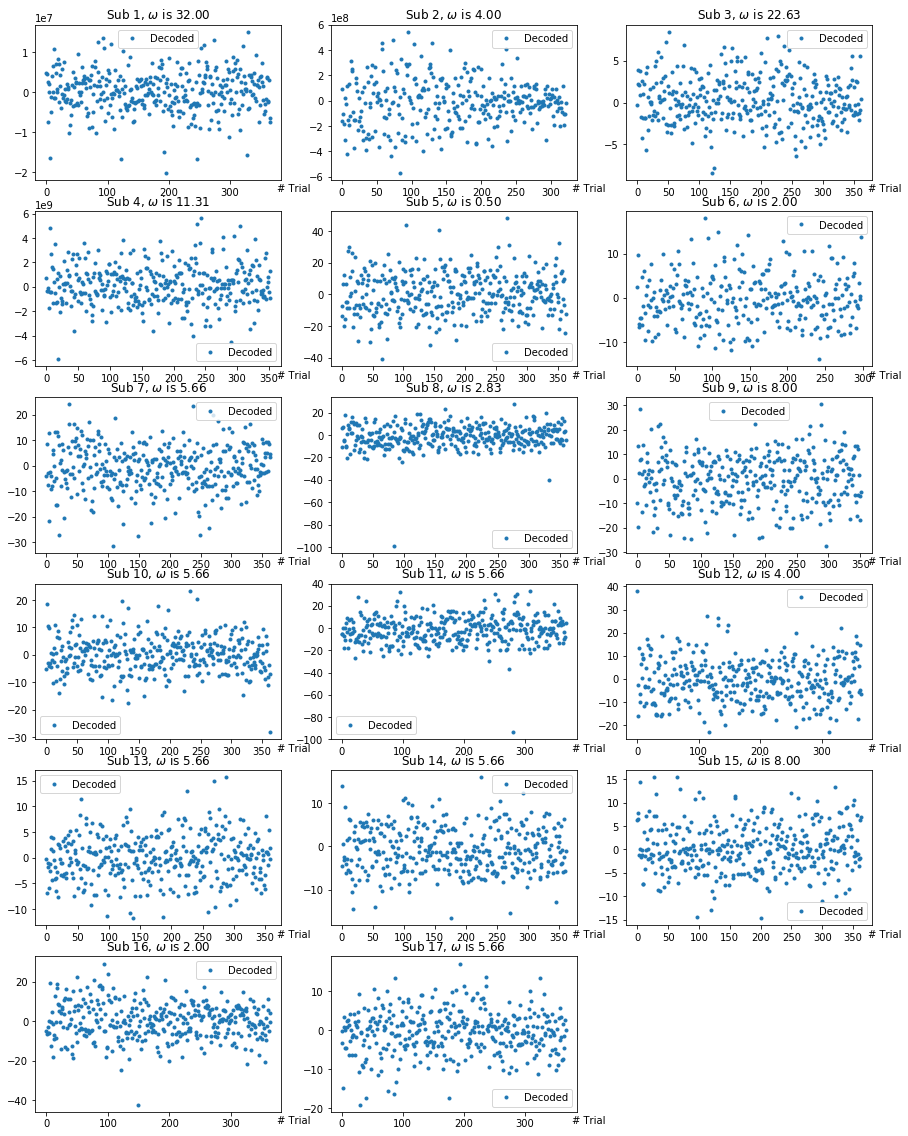

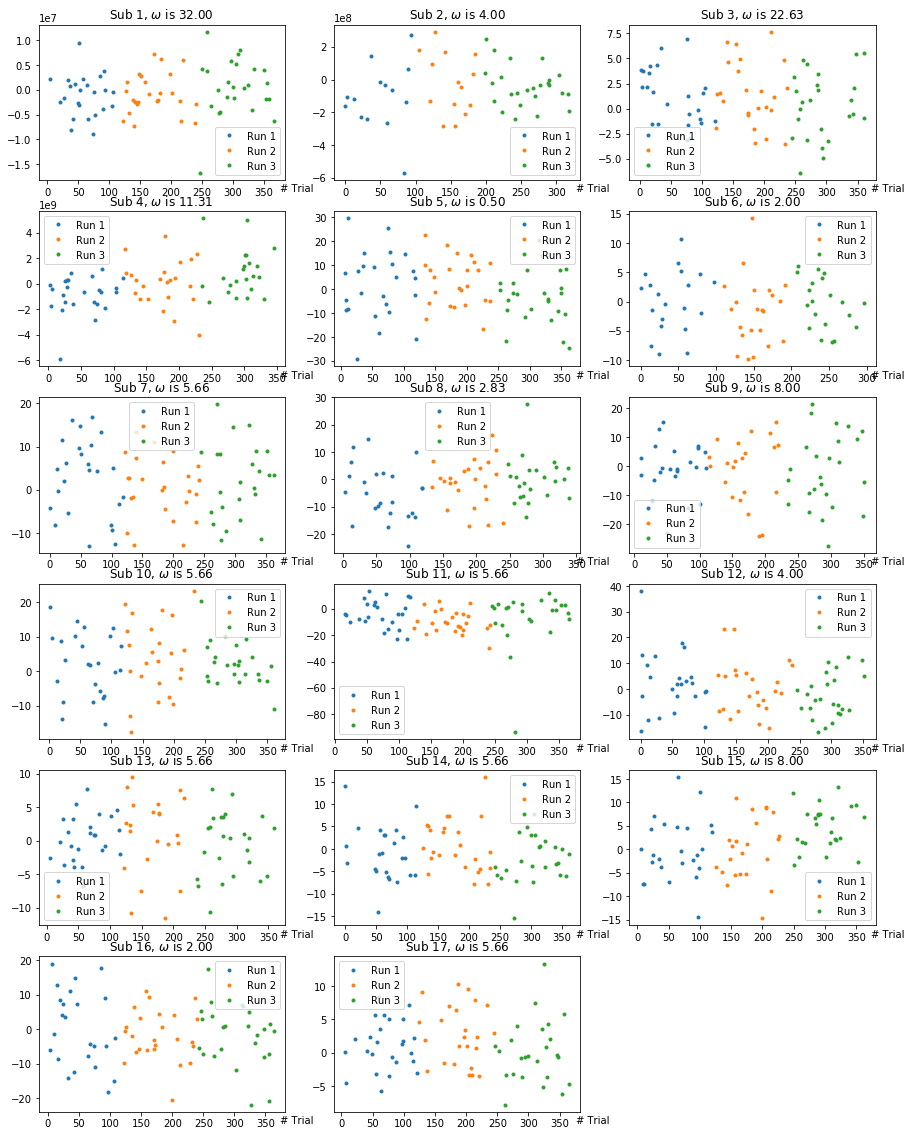

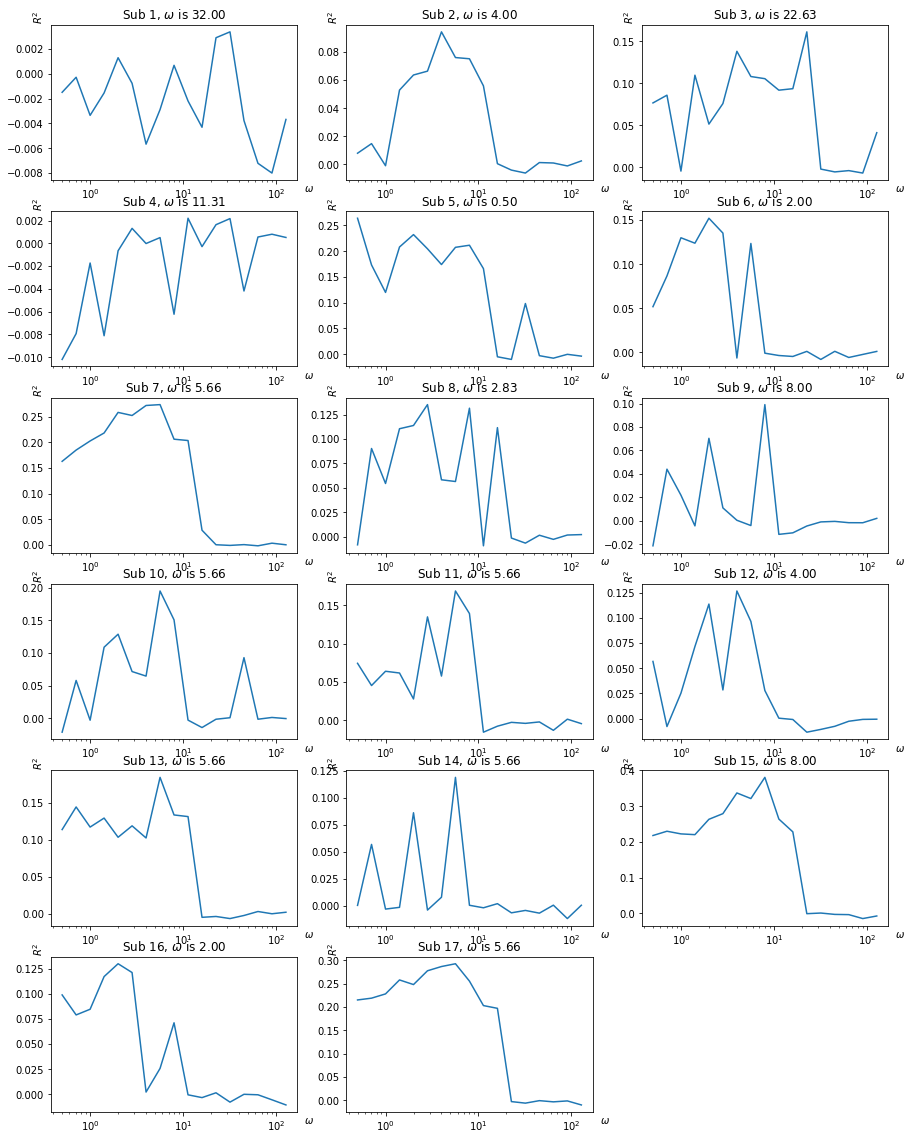

/usr/local/share/.virtualenvs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


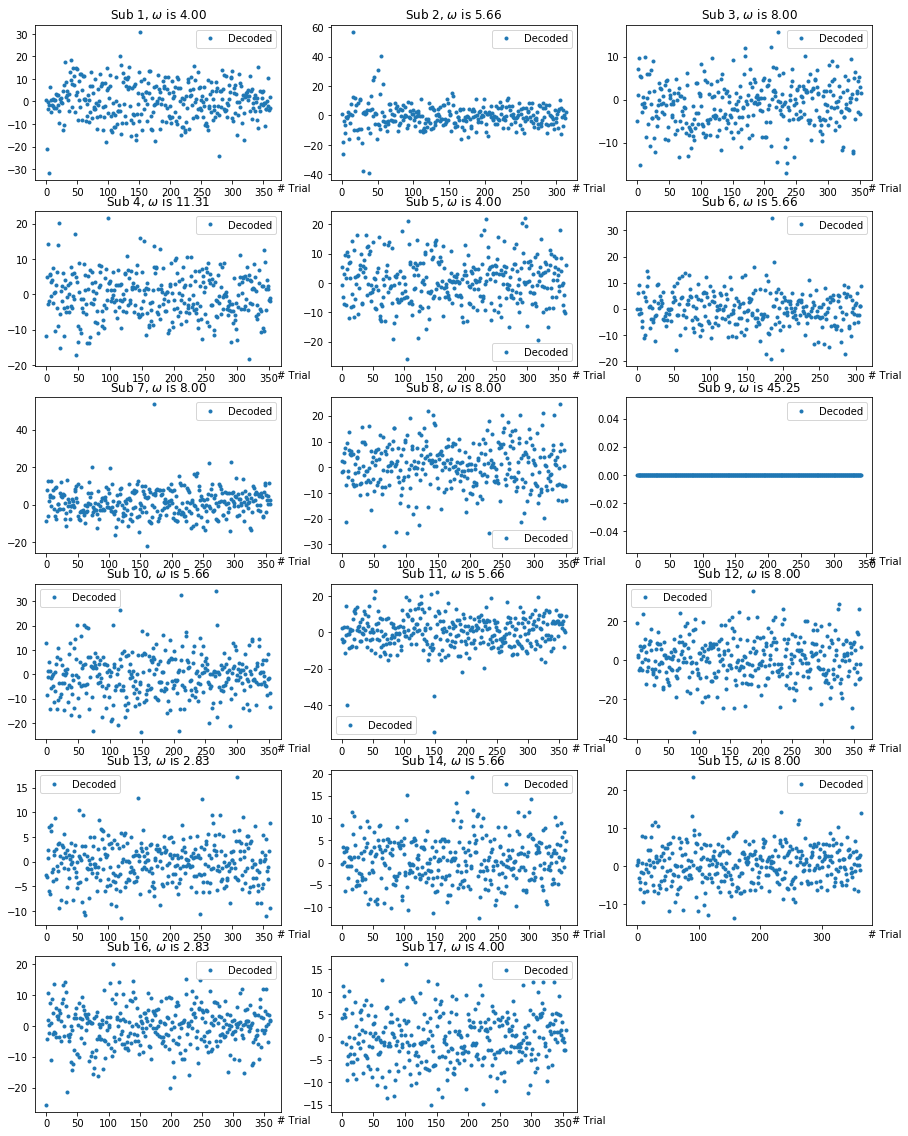

/usr/local/share/.virtualenvs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


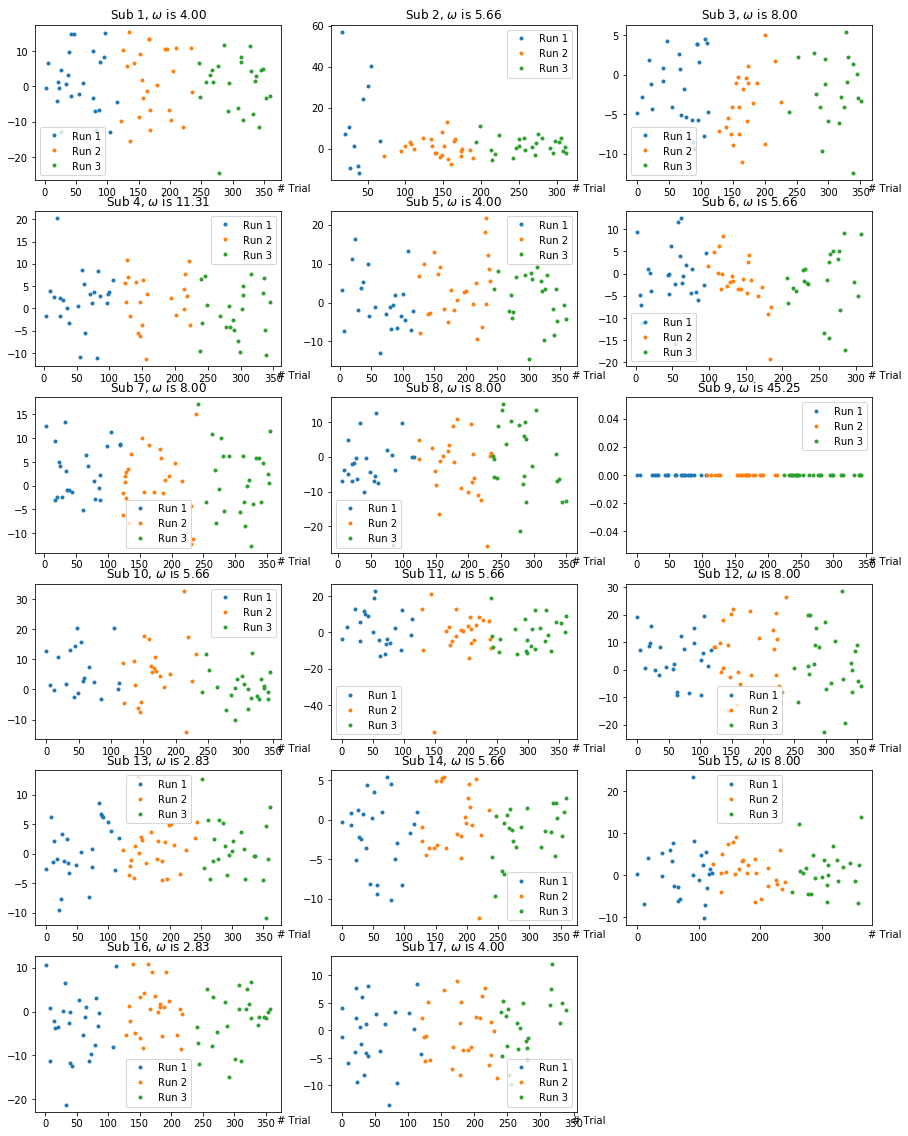

/usr/local/share/.virtualenvs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


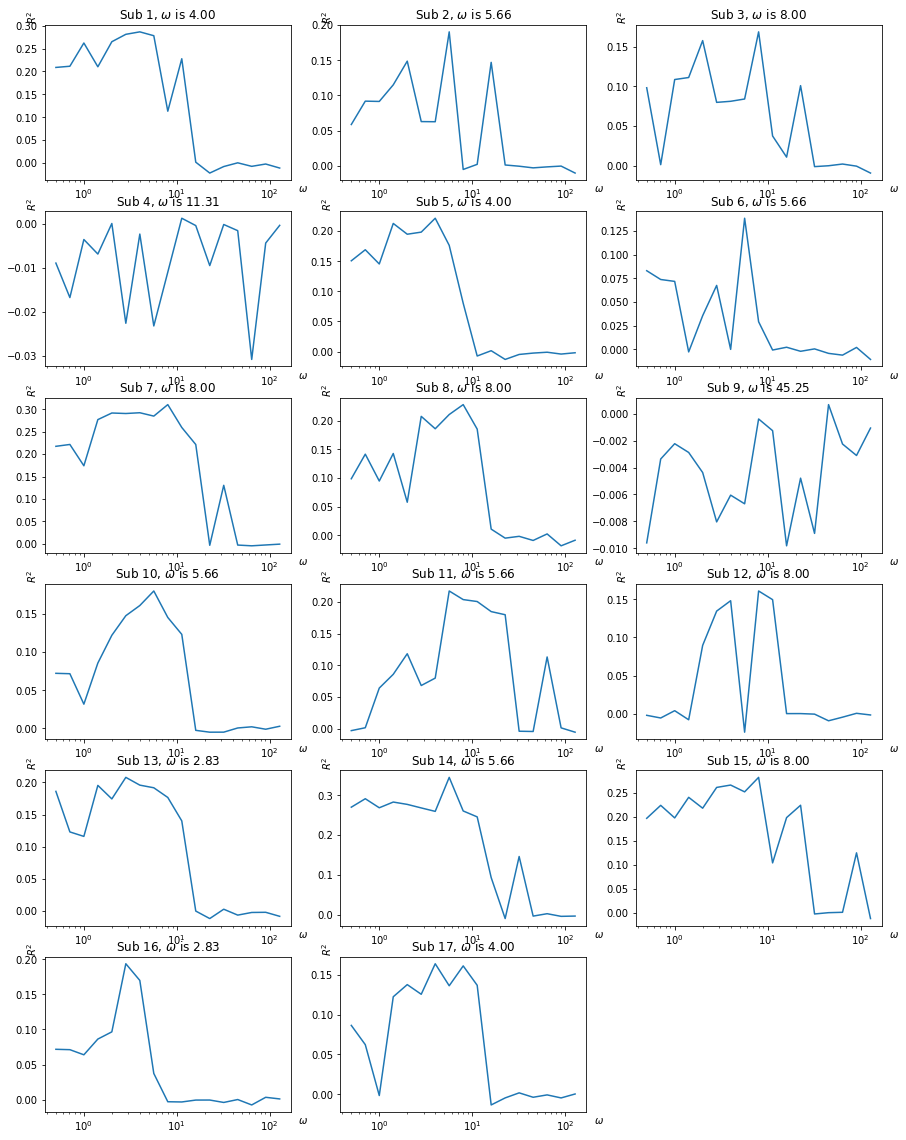

In [80]:
# plotting_data = {}
ncols = 3
nrows = int(np.ceil(17/ncols))
figsize = (15, 20) #(5*ncols, 4*nrows)


for SurpriseMethod, Period, learn_method, TaskNumber in \
    itertools.product(SurpriseMethods_list, Periods_list, Learn_methods_list, Tasks_list,):
    
    plt.figure(figsize=figsize)
    
    for Sub in Subjects_list:
        key = f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'
        X, beta, argument, W, kl2, SoD, run, seqidx = plotting_data[key]
        decoded = np.dot(X, beta[:, argument])
        ndecoded = decoded / decoded.max()
        kl2 = kl2.squeeze()
        kl2 /= kl2.max()
        
        ax = plt.subplot(nrows, ncols, Sub)
        #plt.subplots_adjust(hspace = 0.4)
        plt.plot(decoded, label='Decoded', color='#1f77b4', marker='.', linestyle='')
        #plt.plot(kl2, label='Normalized Target', color='#ff7f0e', marker='.', linestyle='')
        #plt.plot(kl2 - ndecoded, label='Difference', color='#2ca02c', marker='.', linestyle='')
        plt.legend()
        plt.title(f'Sub {Sub}, $\omega$ is {W:0.2f}')
        plt.xlabel('# Trial')
        ax.xaxis.set_label_coords(1.05, -0.025)
        # plt.ylabel('${R^2}$')

    plt.show()
    
    plt.figure(figsize=figsize)
    
    for Sub in Subjects_list:
        key = f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'
        X, beta, argument, W, kl2, SoD, run, seqidx = plotting_data[key]
        decoded = np.dot(X, beta[:, argument])
        ndecoded = decoded / decoded.max()
        kl2 = kl2.squeeze()
        kl2 /= kl2.max()
        t = np.arange(0, decoded.shape[0])
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        ax = plt.subplot(nrows, ncols, Sub)
        for i in range(1, 4):
            plt.plot(t[(SoD == 1) * (run == i)], decoded[(SoD == 1) * (run == i)],
                     label=f'Run {i}', color=colors[i - 1], marker='.', linestyle='')
        #plt.plot(kl2, label='Normalized Target', color='#ff7f0e', marker='.', linestyle='')
        #plt.plot(kl2 - ndecoded, label='Difference', color='#2ca02c', marker='.', linestyle='')
        plt.legend()
        plt.title(f'Sub {Sub}, $\omega$ is {W:0.2f}')
        plt.xlabel('# Trial')
        ax.xaxis.set_label_coords(1.05, -0.025)
        #plt.ylabel('$R^{2}$')

    plt.show()
    
    plt.figure(figsize=figsize)
    
    for Sub in Subjects_list:
        key = f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'
        data = decoding_powers[key]
        X, beta, argument, W, kl2, SoD, run, seqidx = plotting_data[key]
        decoded = np.dot(X, beta[:, argument])
        ndecoded = decoded / decoded.max()
        kl2 = kl2.squeeze()
        kl2 /= kl2.max()
        t = np.arange(0, decoded.shape[0])
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        ax = plt.subplot(nrows, ncols, Sub)
        plt.plot(data['data'][0, 0]['Param'][0, 0]['w_Set'].T, data['data'][0, 0]['Model_Rs'][0, 0]['R_CV'])
        plt.title(f'Sub {Sub}, $\omega$ is {W:0.2f}')
        plt.xscale('log')
        #plt.legend()
        plt.title(f'Sub {Sub}, $\omega$ is {W:0.2f}')
        plt.xlabel('$\omega$')
        ax.xaxis.set_label_coords(1.05, -0.025)
        plt.ylabel('$R^{2}$')
        ax.yaxis.set_label_coords(-0.025, 1.05)

    plt.show()
    
        
    
#     plt.figure(figsize=(15, 20))
    
#     for Sub in Subjects_list:
#         key = f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'
#         X, beta, argument, W, kl2, SoD, run = plotting_data[key]
#         decoded = np.dot(X, beta[:, argument])
#         ndecoded = decoded / decoded.max()
#         kl2 = kl2.squeeze()
#         kl2 /= kl2.max()
#         plt.subplot(5, 4, Sub)
#         plt.plot(ndecoded, label='Normalized Decoded', color='#1f77b4', marker='.', linestyle='')
#         plt.plot(kl2, label='Normalized Target', color='#ff7f0e', marker='.', linestyle='')
#         plt.plot(kl2 - ndecoded, label='Difference', color='#2ca02c', marker='.', linestyle='')
#         plt.legend()
#         plt.title(f'Sub {Sub}, $\omega$ is {W:0.2f}')

#     plt.show()
    

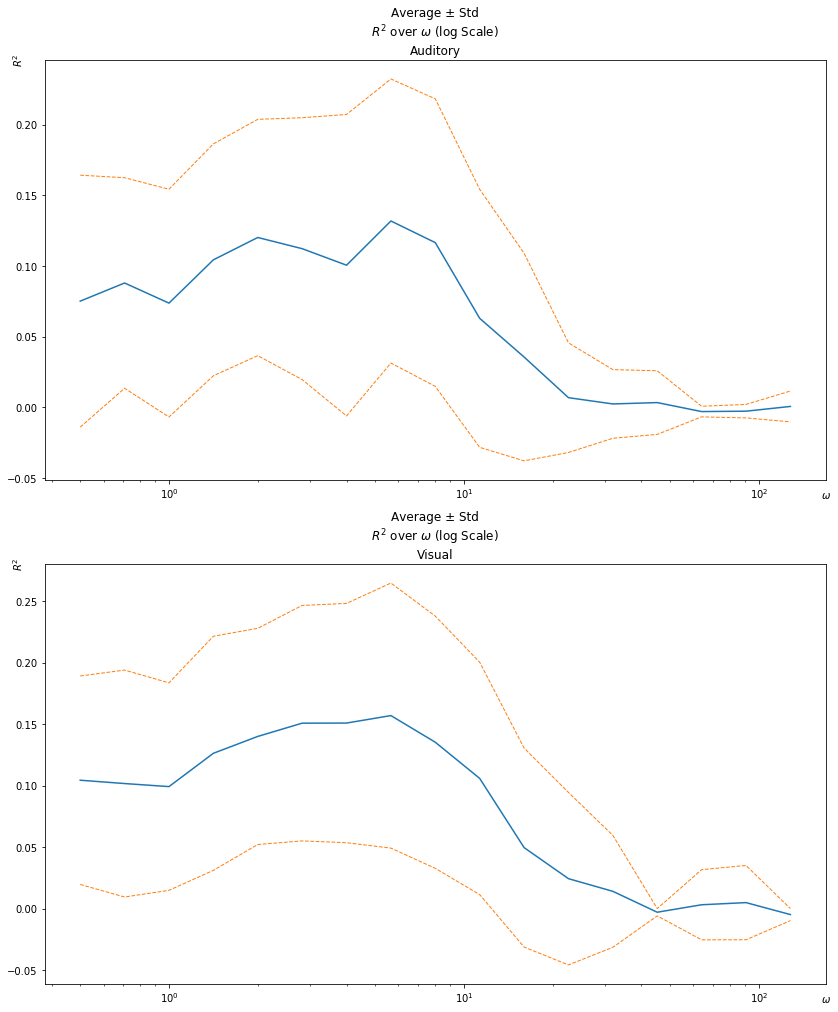

In [105]:
# plotting_data = {}
ncols = 3
nrows = int(np.ceil(17/ncols))
figsize = (14, 17) #(5*ncols, 4*nrows)

plt.figure(figsize=figsize)

for SurpriseMethod, Period, learn_method, TaskNumber in \
    itertools.product(SurpriseMethods_list, Periods_list, Learn_methods_list, Tasks_list,):
    
    ax = plt.subplot(2, 1, TaskNumber)
    
    decoded = []
    for Sub in Subjects_list:
        key = f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'
        data = decoding_powers[key]
        X, beta, argument, W, kl2, SoD, run, seqidx = plotting_data[key]
        decoded.append(data['data'][0, 0]['Model_Rs'][0, 0]['R_CV'])
        
    

    plt.plot(data['data'][0, 0]['Param'][0, 0]['w_Set'].T, np.asarray(decoded).mean(axis=0))
    plt.plot(data['data'][0, 0]['Param'][0, 0]['w_Set'].T,
             np.asarray(decoded).mean(axis=0) + np.asarray(decoded).std(axis=0),
             color='#ff7f0e', linestyle='--', linewidth=1)
    plt.plot(data['data'][0, 0]['Param'][0, 0]['w_Set'].T,
             np.asarray(decoded).mean(axis=0) - np.asarray(decoded).std(axis=0),
             color='#ff7f0e', linestyle='--', linewidth=1)

    #plt.legend()
    plt.title(f'Average ± Std\n$R^2$ over $\omega$ (log Scale)\n{"Auditory" if TaskNumber == 1 else "Visual"}')
    plt.xlabel('$\omega$')
    plt.xscale('log')
    ax.xaxis.set_label_coords(1.0, -0.025)
    plt.ylabel('$R^{2}$')
    ax.yaxis.set_label_coords(-0.025, 1.0)

plt.show()
    
        
    
#     plt.figure(figsize=(15, 20))
    
#     for Sub in Subjects_list:
#         key = f'{SurpriseMethod}_{Period}_{learn_method}_{TaskNumber}_{Sub}'
#         X, beta, argument, W, kl2, SoD, run = plotting_data[key]
#         decoded = np.dot(X, beta[:, argument])
#         ndecoded = decoded / decoded.max()
#         kl2 = kl2.squeeze()
#         kl2 /= kl2.max()
#         plt.subplot(5, 4, Sub)
#         plt.plot(ndecoded, label='Normalized Decoded', color='#1f77b4', marker='.', linestyle='')
#         plt.plot(kl2, label='Normalized Target', color='#ff7f0e', marker='.', linestyle='')
#         plt.plot(kl2 - ndecoded, label='Difference', color='#2ca02c', marker='.', linestyle='')
#         plt.legend()
#         plt.title(f'Sub {Sub}, $\omega$ is {W:0.2f}')

#     plt.show()
    